In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from functions import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
model = load_vgg_model("models/imagenet-vgg-verydeep-19.mat")

In [3]:
def compute_content_cost(a_C, a_G):

    # Retrieve dimensions of a_G
    m, n_H, n_W, n_C =a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C,shape=[m,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,n_H*n_W,n_C])
    
    # Cost computation
    J_content = tf.reduce_sum(tf.square(a_C_unrolled-a_G_unrolled))/(4*n_H*n_W*n_C)

    
    return J_content

In [4]:
def gram_matrix(A):

    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [5]:
def compute_layer_style_cost(a_S, a_G):

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W
    a_S = tf.reshape(a_S,[n_C,n_H*n_W])
    a_G = tf.reshape(a_G,[n_C,n_H*n_W])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(GS-GG))/(4*(n_C*n_W*n_H)**2)
    
    
    return J_style_layer

In [6]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [7]:
def compute_style_cost(model, STYLE_LAYERS):

    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha*J_content+beta*J_style

    
    return J

In [9]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [38]:
content_image = scipy.misc.imread("images/memory clocks.jpeg")
#content_image = scipy.misc.imresize(content_image, size = (1,400,300,3))
content_image = reshape_and_normalize_image(content_image)

style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

C:\Users\sukum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\sukum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


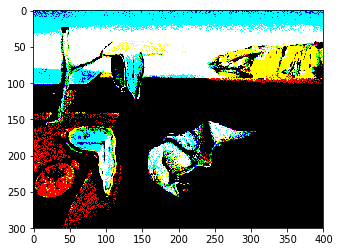

In [39]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [31]:
model = load_vgg_model("models/imagenet-vgg-verydeep-19.mat")

In [40]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [41]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [42]:
# Compute the total cost
J = total_cost(J_content,J_style,alpha=10,beta=40)

In [43]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

In [44]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [45]:
model_nn(sess, generated_image, num_iterations = 1000)

Iteration 0 :
total cost = 1123144100.0
content cost = 12172.381
style cost = 28075560.0
Iteration 20 :
total cost = 82714060.0
content cost = 20758.93
style cost = 2062661.9
Iteration 40 :
total cost = 52551584.0
content cost = 22658.117
style cost = 1308125.1
Iteration 60 :
total cost = 42000090.0
content cost = 23314.17
style cost = 1044173.7
Iteration 80 :
total cost = 35946930.0
content cost = 23778.395
style cost = 892728.56
Iteration 100 :
total cost = 32032480.0
content cost = 24235.654
style cost = 794753.1
Iteration 120 :
total cost = 29390416.0
content cost = 24709.914
style cost = 728582.9
Iteration 140 :
total cost = 27497694.0
content cost = 25164.105
style cost = 681151.3
Iteration 160 :
total cost = 26034372.0
content cost = 25581.469
style cost = 644463.94
Iteration 180 :
total cost = 24835792.0
content cost = 25976.3
style cost = 614400.75
Iteration 200 :
total cost = 23819294.0
content cost = 26339.383
style cost = 588897.5
Iteration 220 :
total cost = 22943912.0
con

array([[[[-140.89005   ,  -89.820724  ,  -24.607668  ],
         [ -94.16004   ,  -36.48782   ,    6.8394537 ],
         [ -87.61803   ,  -34.869587  ,  -20.702244  ],
         ...,
         [-147.6041    ,  -73.38332   ,    5.8106384 ],
         [-137.45045   ,  -50.6695    ,    0.73775876],
         [ -61.15507   ,   23.726746  ,   52.086906  ]],

        [[ -65.08968   ,  -44.342487  ,    2.3913898 ],
         [ -53.614315  ,  -26.387247  ,   -1.6234908 ],
         [ -48.96769   ,  -41.219387  ,    7.523072  ],
         ...,
         [-114.6992    , -103.95911   ,   32.59495   ],
         [-101.59611   ,  -36.77715   ,   32.578568  ],
         [-176.44879   ,  148.3055    ,  127.76048   ]],

        [[ -89.64415   ,  -73.08575   ,  -38.17027   ],
         [ -52.610935  ,  -23.397226  ,  -16.43103   ],
         [ -41.85617   ,  -31.252422  ,  -39.12222   ],
         ...,
         [ -15.131636  ,  -64.68734   ,    6.3832846 ],
         [ -55.177032  ,  -14.914107  ,   21.864677  ],
  